---

## **Série temporal de precipitação do CHIRPS**

---

**Descrição:**
Aprender a produzir e analisar série temporal de precipitação. Para isso serão utilizados a base de dados de precipitação do **Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)**. CHIRPS é uma base de dados de precipitação desenvolvida em colaboração com o centro *USGS Earth Resources Observation and Science (EROS)* para análises de tendência e monitoramento de seca sazonal. Os dados são uma combinação de precipitação estimada por satélite e estações de superfície. Esta base de dados possui mais de 35 anos de dados (desde 1981) e cobertura quase-global, compreendendo entre 50°S-50°N. Os dados de precipitação possuem resolução espacial de 0.05° e temporal diária.



---



**DADOS DE ENTRADA**: Base de dados de precipitação diária do Climate Hazards Group InfraRed Precipitation (CHIRPS).

- **Base de dados:** [CHIRPS Daily: Climate Hazards Group InfraRed Precipitation With Station Data (Version 2.0 Final)](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)
- **Período:** 1981-01-01T00:00:00Z–2023-05-31T00:00:00
- **Fornecedor:** [UCSB/CHG](https://chc.ucsb.edu/data/chirps)
- **Earth Engine Snippet:** ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
- **Resolução espacial:** 5566 m
- **Resolução temporal:** diária

---

**DADOS DE SAÍDA:**
- **Tipo do dado:** Figuras e planilha
- **Formato do dado:** arquivos JPG e CSV
- **Informações/dados gerados:**
    1. SaoSebastiao_Fig1_precipitacao_total_chirps.jpg
    2. SaoSebastiao_Fig2_precipitacao_ano_chirps.jpg
    3. SaoSebastiao_Fig3_precipitacao_mensal_distribuicao_chirps.jpg
    4. SaoSebastiao_Fig4_precipitacao_mensal_linear_chirps.jpg
    5. SaoSebastiao_Fig5_precipitacao_mensal_climatologica_chirps.jpg
    6. precipitacao_diaria_chirps_SaoSebastiao_total.csv

---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Inicializando GEE
2.   Monta o google drive
3.   Define o caminho do google drive
4.   Importa shapefile do município
5.   Gerando série temporal para o período de 2010-2022
6.   Gerando série temporal para o período de 1981-2023
7.   Gerando as estatísticas
8.   Gráficos:
     - Total diário
     - Por ano
     - Boxplot mensal
     - Por mês
     - Mensal climatológica


---
**OBSERVAÇÕES IMPORTANTES**:
1. Criar conta no Google Earth Engine
2. Caminho do seu drive
---

**Maiores informações:**

- [The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes](https://www.nature.com/articles/sdata201566).
- https://github.com/aazuspan/wxee/blob/main/docs/examples/climatology_mean.ipynb
- https://coder.social/aazuspan/wxee
- https://wxee.readthedocs.io/_/downloads/en/latest/pdf/

---

- **Realizado por:** Enrique V. Mattos - 18/09/2022
- **Atualizado por:** Enrique V. Mattos - 07/07/2023

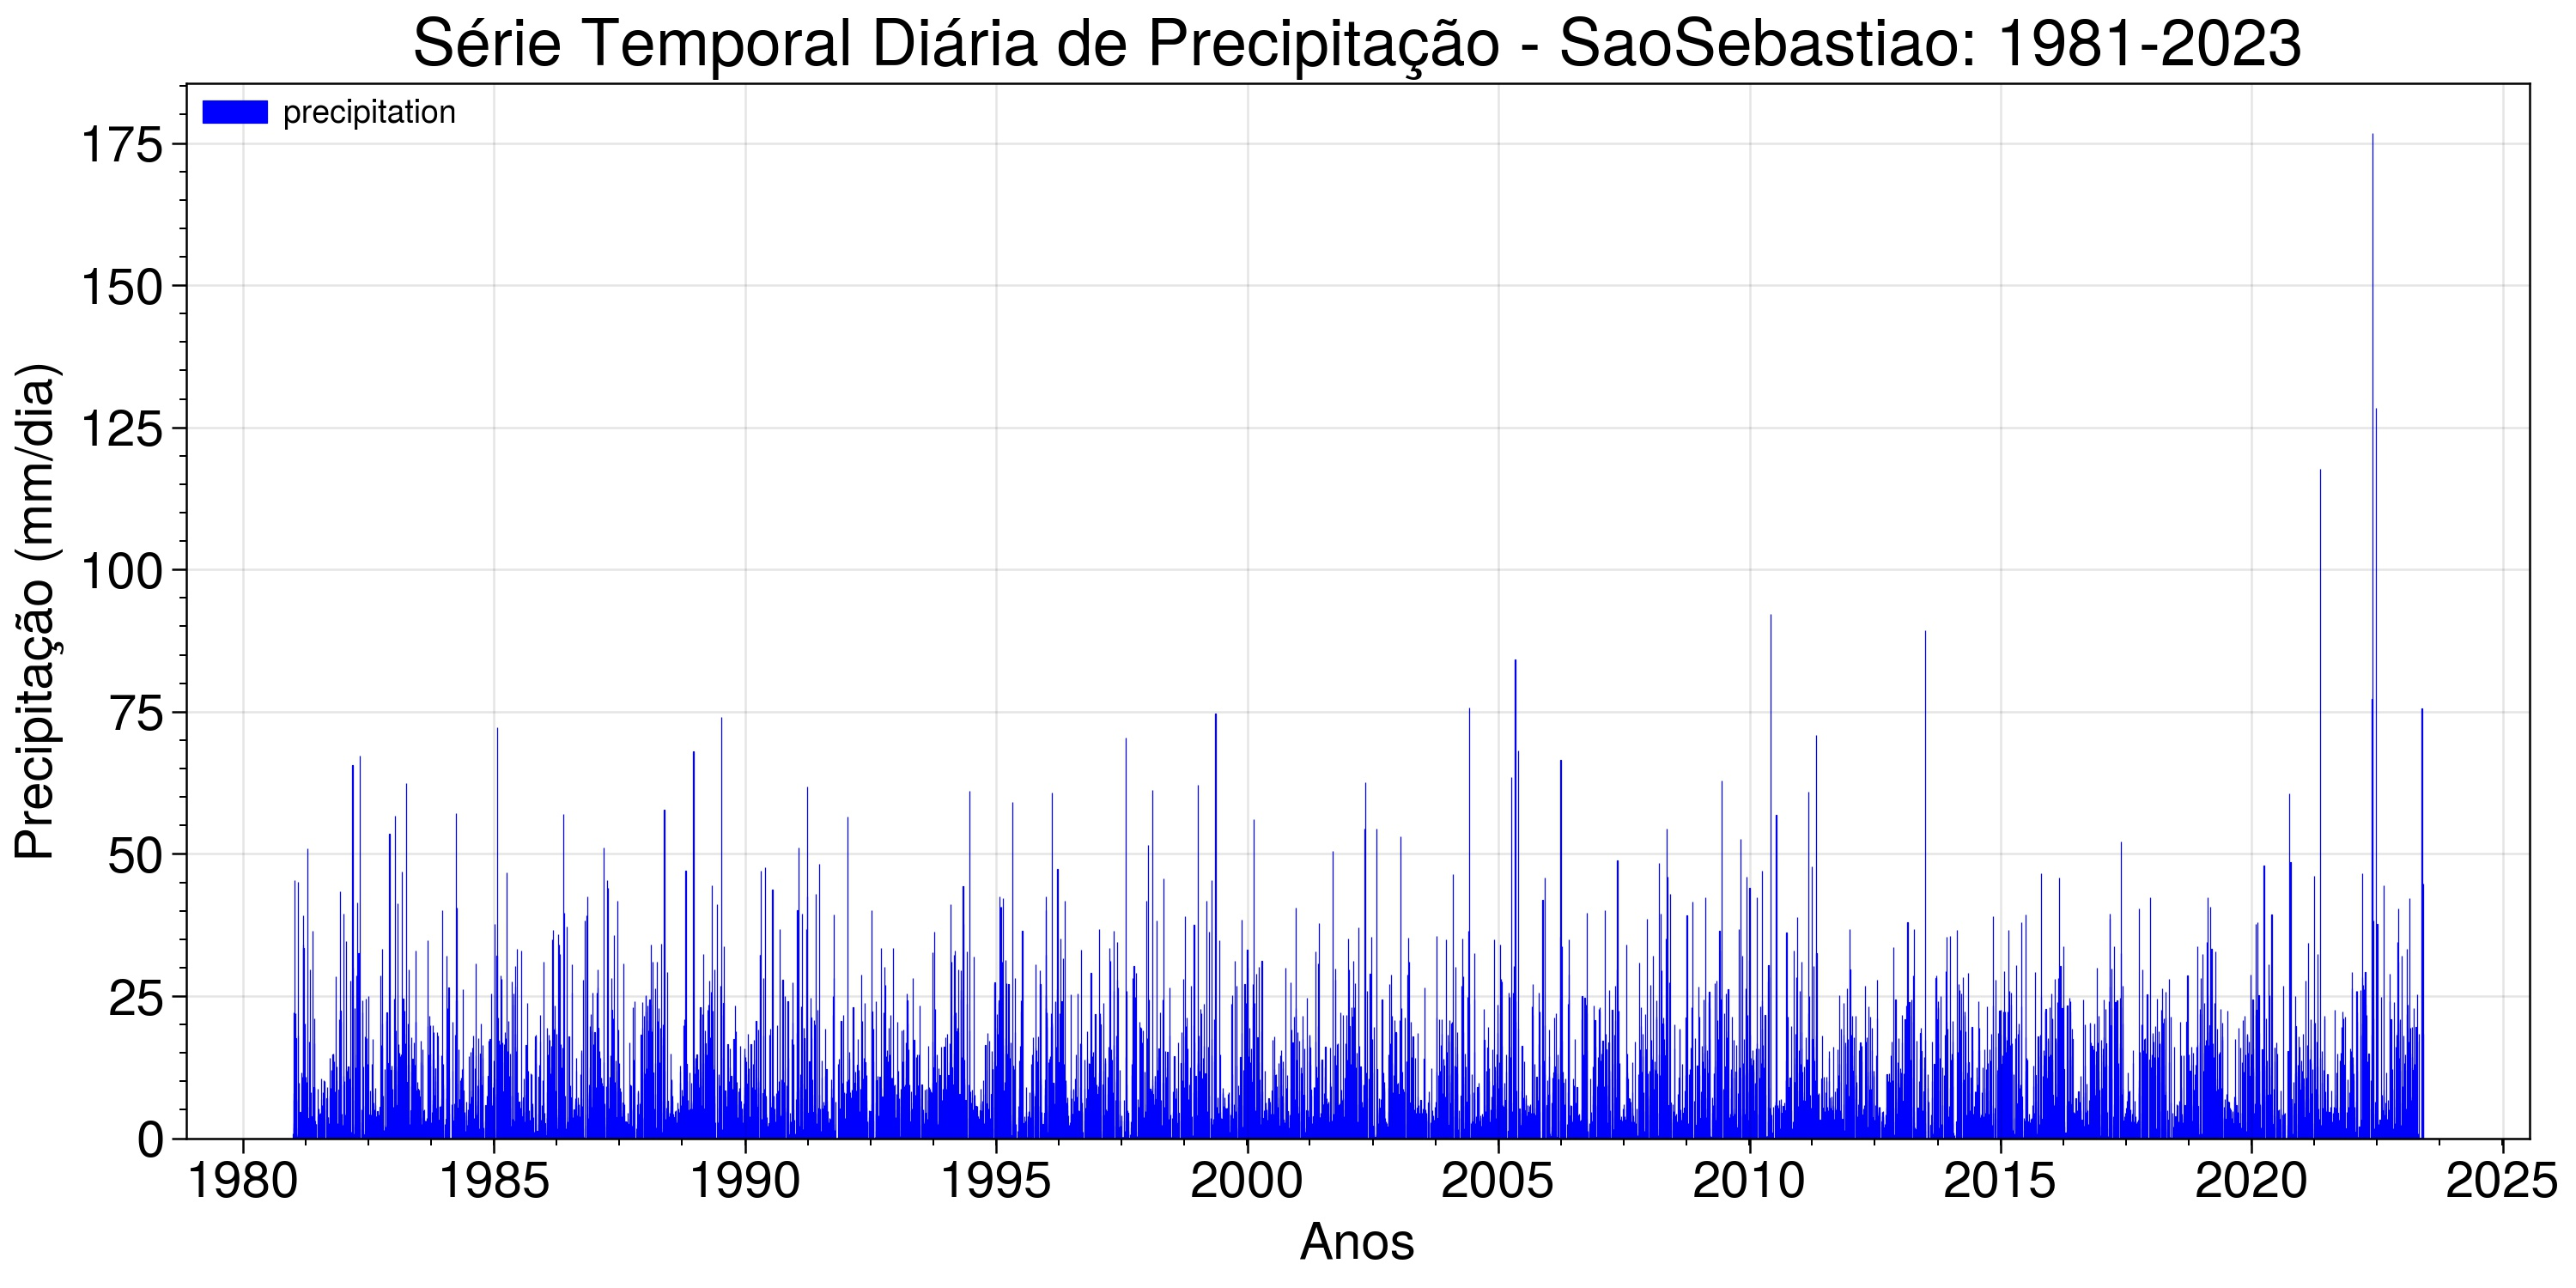

# **1° Passo:** Inicializando GEE

Instalando geemap e inicializando GEE

In [1]:
# instalando geemap
!pip install geemap -q

# importando GEE e geemap
import ee
import geemap

# inicializando GEE
geemap.ee_initialize()

Instalando e importando demais bibliotecas

In [2]:
# instalando eemont, wxee, seaborn e proplot
!pip install eemont -q
!pip install wxee -q
!pip install seaborn -q
!pip install proplot -q

# importando bibliotecas
import eemont
import wxee
import os
import numpy as np
import pandas as pd
import seaborn as sns
import proplot as pplt
import matplotlib.pyplot as plt

# vamos ignorar avisos desnecessários no código
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


Chegando aqui, será necessário fazer a tediosa **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

# **2° Passo:** Montando Drive

In [3]:
# monta drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3° Passo:** Caminho do diretório

In [30]:
# caminho do diretório do código
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/12_Precipitacao_CHIRPS/'

In [31]:
# criando a pasta de saída "output"
os.makedirs(f'{dir}output', exist_ok=True)

#**PARTE 1):** Importando shapefiles

In [6]:
# Vamos filtrar o conjunto de shapefiles com a função `.filter()` e escolher apenas a área de `São Sebastião`
regiao = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Sebastiao'))

# uma alternativa seria utilizar a localização de um ponto.
#lon, lat, city = -53.75, -29.75
#regiao = ee.Geometry.Point([lon, lat]).buffer(10000)

In [11]:
# mostrando o mapa da região
Map = geemap.Map()
Map.addLayer(regiao, {}, 'São Sebastião')
Map.centerObject(regiao)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

#**PARTE 2):** Gerando a série temporal para o período de 2010-2022

In [21]:
# carrega os dados
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
           .filterDate('2010', '2022') \
           .filterBounds(regiao) \
           .select('precipitation')

In [22]:
# gera a série temporal
chirps_ts = chirps.getTimeSeriesByRegion(geometry = regiao,
                                         bands = 'precipitation',
                                         reducer = ee.Reducer.mean(),
                                         scale = 10000)

In [23]:
# inserindo os dados numa tabela
chirps_ts = geemap.ee_to_pandas(chirps_ts)

In [24]:
# transformando -9999.0 em NaN
chirps_ts[chirps_ts == -9999] = np.nan

# eliminando os dados NaN
chirps_ts = chirps_ts.dropna()

In [25]:
# transformando para DateTime
chirps_ts['date'] = pd.to_datetime(chirps_ts['date'], infer_datetime_format = True)

In [26]:
# transformando a coluna de datas('date') no índice do DataFrame
chirps_ts.index = chirps_ts['date']

In [27]:
# mostra a tabela da série temporal
chirps_ts

,reducer,date,precipitation
date,,,
2010-01-01,mean,2010-01-01,44.025241
2010-01-02,mean,2010-01-02,18.265657
2010-01-03,mean,2010-01-03,0.000000
2010-01-04,mean,2010-01-04,0.000000
2010-01-05,mean,2010-01-05,0.000000
...,...,...,...
2021-12-27,mean,2021-12-27,0.059550
2021-12-28,mean,2021-12-28,5.378261
2021-12-29,mean,2021-12-29,3.853283


#**PARTE 3):** Gerando a série temporal para o período de 1981-2022

O GEE tem um limite de 5000 tempos. Como precisamos processar de 1981 à 2022 teremos que fazer por partes.

In [90]:
#-------------------------------#
# Delimitação temporal
#-------------------------------#
# tempo: 01 de janeiro de 1981 à 31 de dezembro de 2022, totalizando 42 anos de dados.
time1 = [1981, 1991, 2000, 2010]
time2 = [1991, 2000, 2010, 2024]
city = 'SaoSebastiao'
periodo = f'{str(time1[0])}-{str((time2[-1]-1))}'

# Loop nos períodos
for t1, t2 in zip(time1, time2):

    print('....PROCESSANDO----->>', f'{city}={str(t1)}-{str(t2)}')

    #-------------------------------#
    #     Carrega os dados
    #-------------------------------#
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
               .filterDate(str(t1), str(t2)) \
               .filterBounds(regiao) \
               .select('precipitation')

    #-------------------------------#
    #     Serie temporal
    #-------------------------------#
    # gera a serie temporal
    chirps_ts = chirps.getTimeSeriesByRegion(geometry = regiao,
                                             bands = 'precipitation',
                                             reducer = ee.Reducer.mean(),
                                             scale = 10000)

    # inserindo os dados numa tabela
    chirps_ts = geemap.ee_to_pandas(chirps_ts)

    # transformando -9999.0 em NaN
    chirps_ts[chirps_ts == -9999] = np.nan

    # eliminando os dados NaN
    chirps_ts = chirps_ts.dropna()

    # transformando a coluna "date" para DateTime
    chirps_ts['date'] = pd.to_datetime(chirps_ts['date'], infer_datetime_format=True)

    # transformando a coluna de datas("date") no índice do DataFrame
    chirps_ts.index = chirps_ts['date']

    #-------------------------------#
    #   Salva num arquivo CSV
    #-------------------------------#
    chirps_ts.to_csv(f'/content/precipitacao_diaria_chirps_{city}_{str(t1)}_{str(t2)}.csv')

#-------------------------------#
#      Junta os DataFrames
#-------------------------------#
# leitura dos dataframes
df1 = pd.read_csv(f'/content/precipitacao_diaria_chirps_{city}_{str(time1[0])}_{str(time2[0])}.csv')
df2 = pd.read_csv(f'/content/precipitacao_diaria_chirps_{city}_{str(time1[1])}_{str(time2[1])}.csv')
df3 = pd.read_csv(f'/content/precipitacao_diaria_chirps_{city}_{str(time1[2])}_{str(time2[2])}.csv')
df4 = pd.read_csv(f'/content/precipitacao_diaria_chirps_{city}_{str(time1[3])}_{str(time2[3])}.csv')

# junta os dataframes
df = pd.concat([df1, df2, df3, df4])

# remove colunas
df.drop(['reducer', 'date.1'], inplace=True, axis=1)

# salva tabela final
df.to_csv(f'{dir}output/precipitacao_diaria_chirps_{city}_total.csv')

# transformando para DateTime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df.index = df['date']

# exibe tabela final
df

....PROCESSANDO----->> SaoSebastiao=1981-1991
....PROCESSANDO----->> SaoSebastiao=1991-2000
....PROCESSANDO----->> SaoSebastiao=2000-2010
....PROCESSANDO----->> SaoSebastiao=2010-2024


,date,precipitation
date,,
1981-01-01,1981-01-01,0.860823
1981-01-02,1981-01-02,0.000000
1981-01-03,1981-01-03,2.691075
1981-01-04,1981-01-04,0.533462
1981-01-05,1981-01-05,7.975275
...,...,...
2023-05-27,2023-05-27,0.080369
2023-05-28,2023-05-28,0.052147
2023-05-29,2023-05-29,18.327121


#**PARTE 4):** Gerando as estatísticas

In [55]:
# mostrando a tabela de dados que será utilizada
df.head()

,date,precipitation
date,,
1981-01-01,1981-01-01,0.860823
1981-01-02,1981-01-02,0.000000
1981-01-03,1981-01-03,2.691075
1981-01-04,1981-01-04,0.533462
1981-01-05,1981-01-05,7.975275


In [56]:
#-------------------------------#
#    Calcula climatologias
#-------------------------------#
# ---------------------------------------------------------- #
#                          MENSAL
# ---------------------------------------------------------- #
# total
mensal = df.groupby(pd.Grouper(freq='1M')).sum()

# climatológica
mensal_climatologia = mensal.groupby(mensal.index.month).mean()

# ---------------------------------------------------------- #
#                          ANUAL
# ---------------------------------------------------------- #
# total
anual = df.groupby(pd.Grouper(freq='1Y')).sum()

In [57]:
mensal

,precipitation
date,
1981-01-31,170.915124
1981-02-28,93.580082
1981-03-31,214.568448
1981-04-30,120.482660
1981-05-31,78.324773
...,...
2023-01-31,130.903592
2023-02-28,318.742575
2023-03-31,153.273789


In [58]:
mensal_climatologia

,precipitation
date,
1,162.990341
2,151.279198
3,170.027750
4,130.882263
5,147.189191
6,88.016563
7,102.669886
8,67.401857
9,92.694381


In [59]:
anual

,precipitation
date,
1981-12-31,1297.027558
1982-12-31,1450.016259
1983-12-31,1717.929477
1984-12-31,1197.885823
1985-12-31,1537.640806
1986-12-31,1712.356908
1987-12-31,1444.856557
1988-12-31,1609.340345
1989-12-31,1587.998903


#**PARTE 5):** Gráficos

###**Plotando gráfico**: total

In [60]:
# mostrando os dados que serão utilizados
df

,date,precipitation
date,,
1981-01-01,1981-01-01,0.860823
1981-01-02,1981-01-02,0.000000
1981-01-03,1981-01-03,2.691075
1981-01-04,1981-01-04,0.533462
1981-01-05,1981-01-05,7.975275
...,...,...
2023-05-27,2023-05-27,0.080369
2023-05-28,2023-05-28,0.052147
2023-05-29,2023-05-29,18.327121


In [62]:
# slicing
df.loc['2023-02-18']

date             2023-02-18 00:00:00
precipitation               9.247351
Name: 2023-02-18 00:00:00, dtype: object

In [64]:
# slicing
df.loc['2023-02']

,date,precipitation
date,,
2023-02-01,2023-02-01,33.279128
2023-02-02,2023-02-02,2.348260
2023-02-03,2023-02-03,11.994736
2023-02-04,2023-02-04,2.291476
2023-02-05,2023-02-05,5.226567
2023-02-06,2023-02-06,23.461594
2023-02-07,2023-02-07,12.925483
2023-02-08,2023-02-08,0.000000
2023-02-09,2023-02-09,0.000000


In [68]:
df['precipitation']

date
1981-01-01     0.860823
1981-01-02     0.000000
1981-01-03     2.691075
1981-01-04     0.533462
1981-01-05     7.975275
                ...    
2023-05-27     0.080369
2023-05-28     0.052147
2023-05-29    18.327121
2023-05-30     0.000000
2023-05-31    44.797462
Name: precipitation, Length: 15491, dtype: float64

In [70]:
df[ df['precipitation'] == df['precipitation'].max()]

,date,precipitation
date,,
2022-05-30,2022-05-30,176.720703


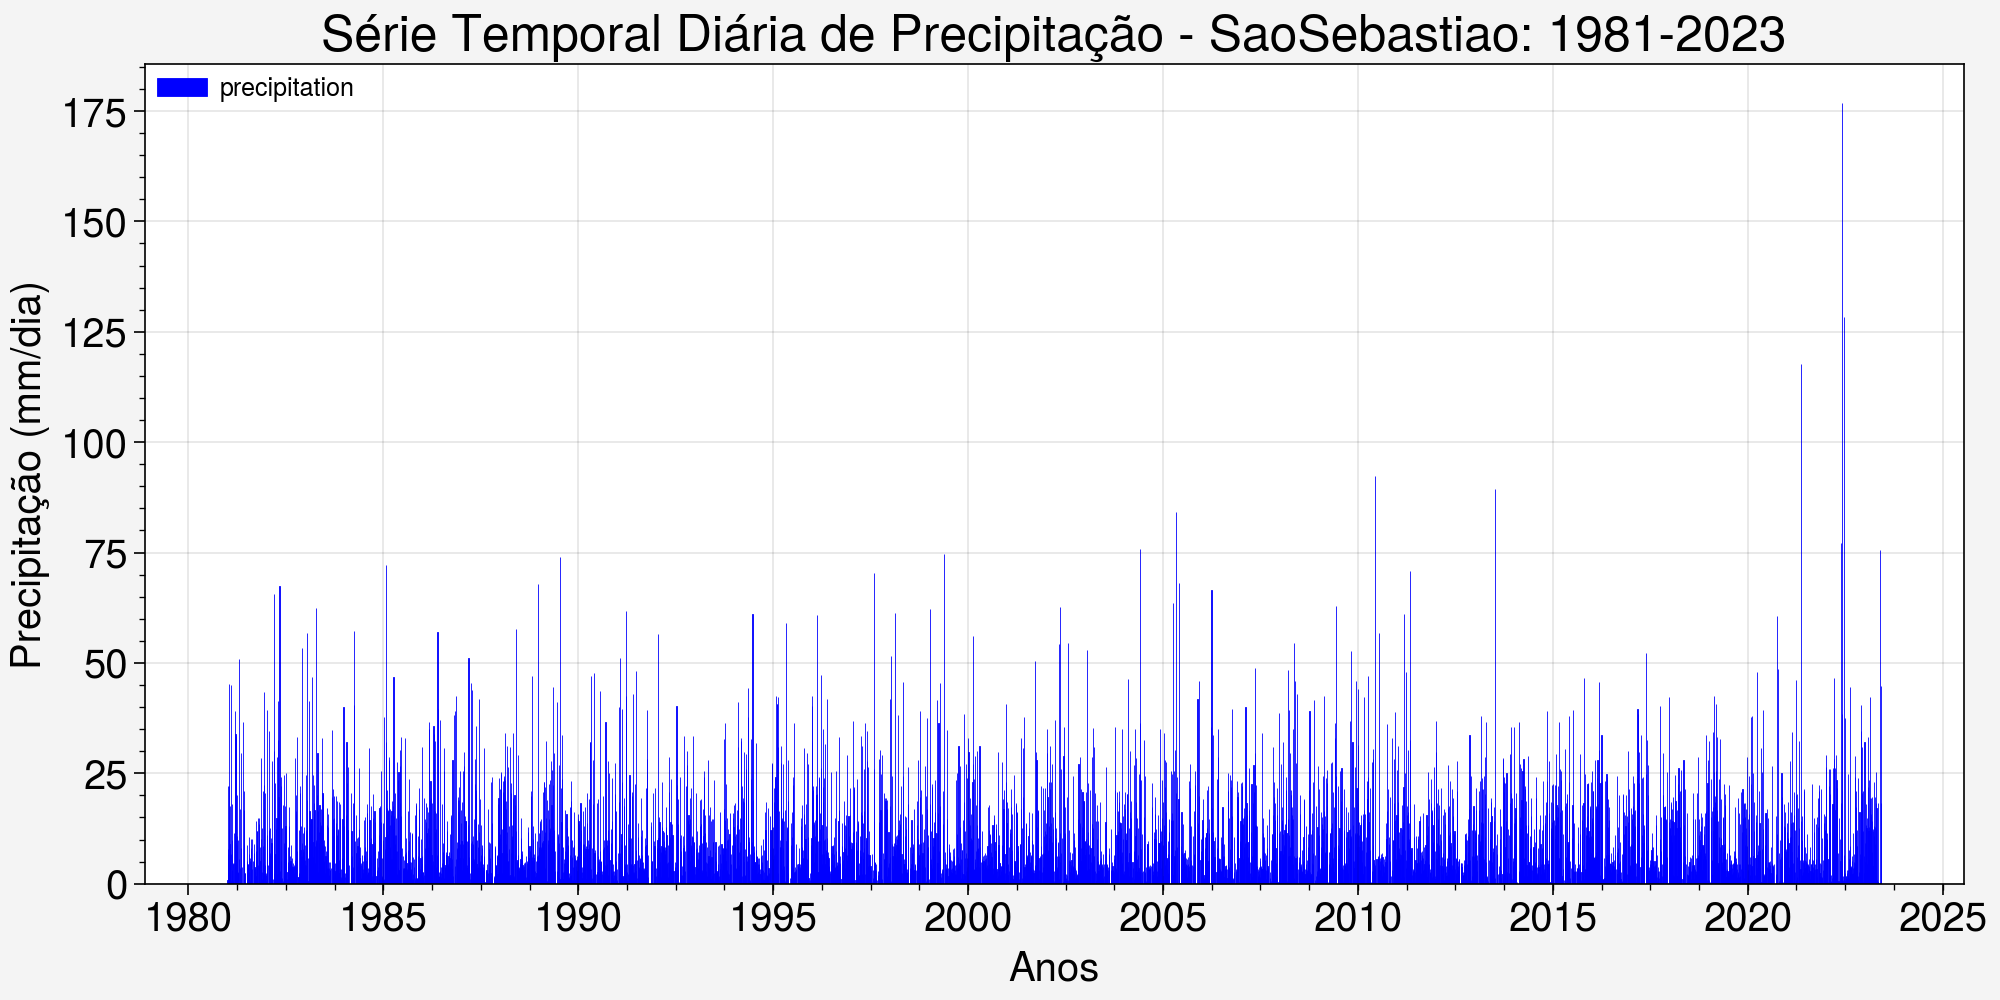

In [91]:
# moldura da figura
fig, ax = pplt.subplots(figsize=(10, 5), tight=True)

# plota gráfico de barras
ax.bar(df['precipitation'].index,
       df['precipitation'],
       color='blue')

# formato dos eixos
ax.format(title=f'Série Temporal Diária de Precipitação - {city}: {periodo}',
          xlabel='Anos',
          ylabel='Precipitação (mm/dia)',
          small='20px', large='25px',
          xrotation=0)

# legenda
ax.legend(frameon=False)

# salva figura
fig.save(f'{dir}output/{city}_Fig1_precipitacao_total_chirps.jpg', dpi=300)

###**Plotando gráfico**: por ano

In [71]:
anual

,precipitation
date,
1981-12-31,1297.027558
1982-12-31,1450.016259
1983-12-31,1717.929477
1984-12-31,1197.885823
1985-12-31,1537.640806
1986-12-31,1712.356908
1987-12-31,1444.856557
1988-12-31,1609.340345
1989-12-31,1587.998903


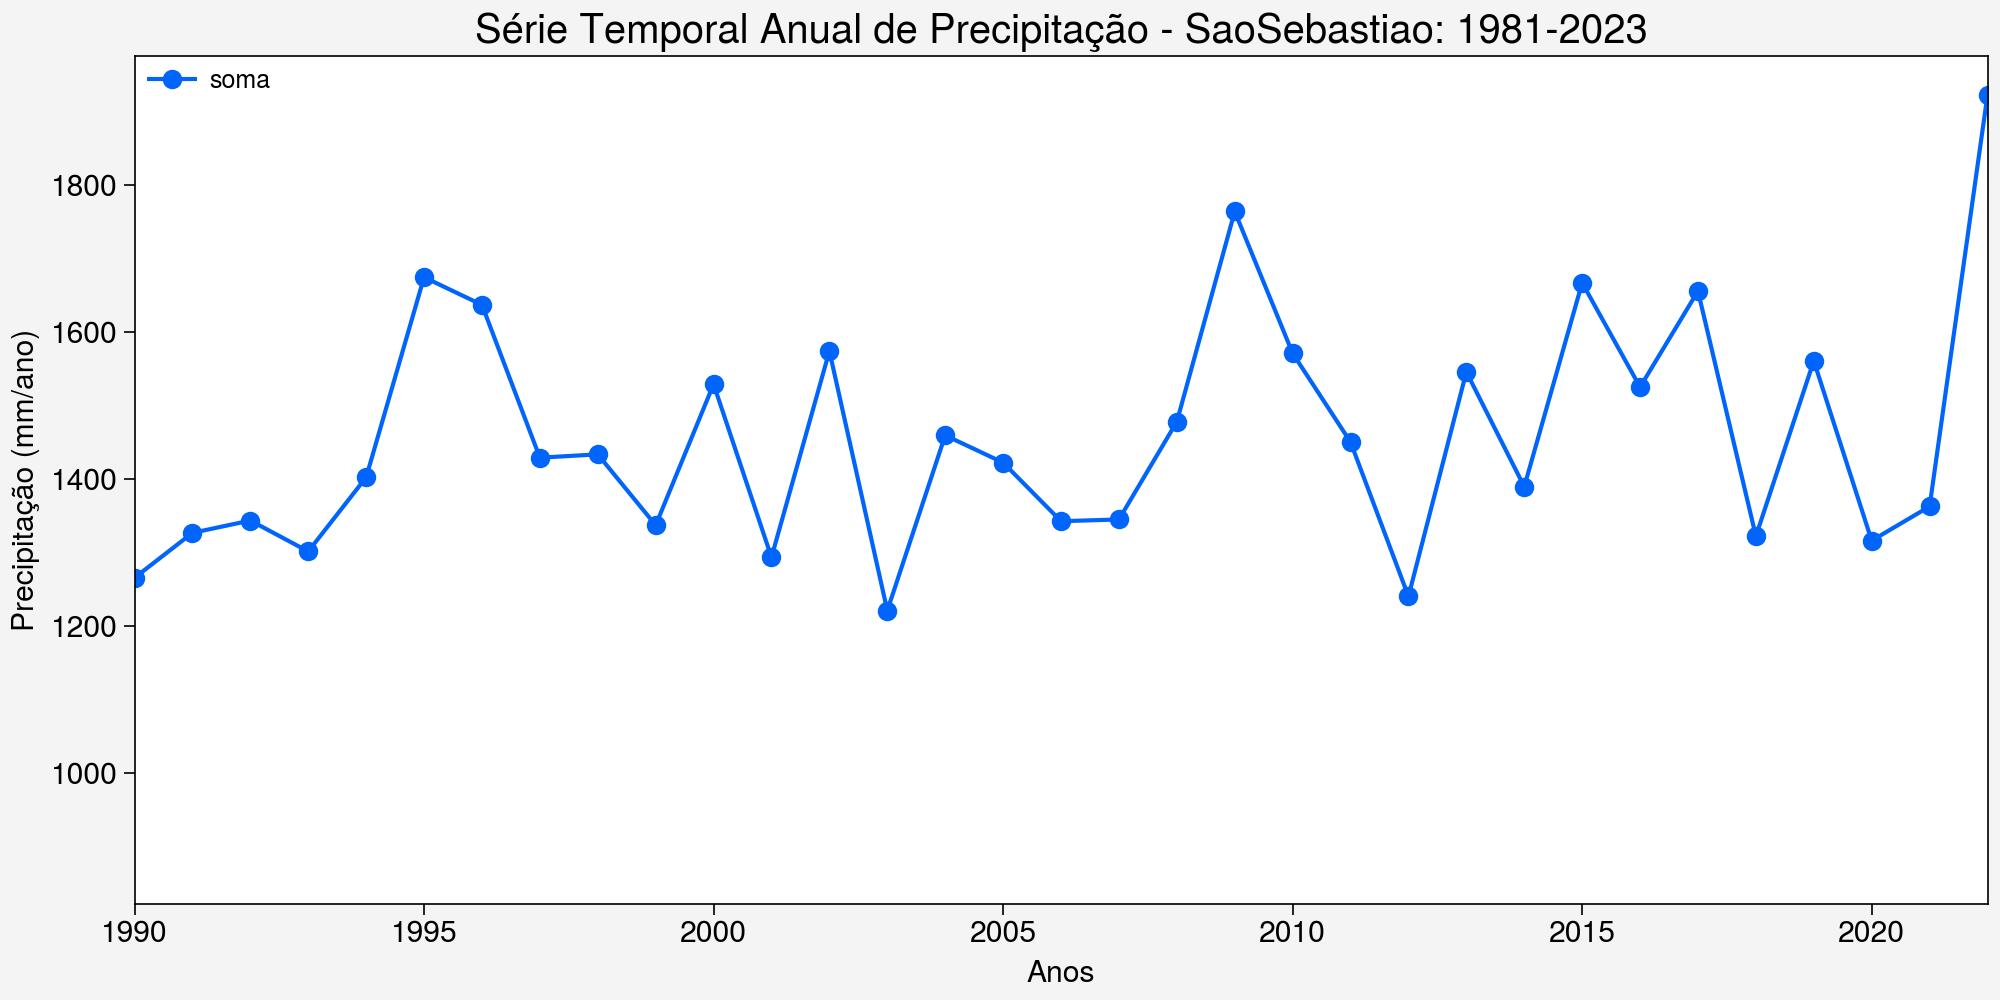

In [92]:
# moldura da figura
fig, ax = pplt.subplots(figsize=(10, 5), tight=True)

# plota figura
ax.plot(pplt.arange(1981, 2023, 1),
        anual['precipitation'].values,
        color='bright blue',
        marker='o',
        label ='soma')

# formato dos eixos
ax.format(xlabel='Anos', ylabel='Precipitação (mm/ano)',
          title=f'Série Temporal Anual de Precipitação - {city}: {periodo}',
          xrotation=0, xtickminor=False, ytickminor=False,
          small='15px', large='20px',
          grid=False,
          xlim=(1990, 2022))

# legenda
ax.legend(frameon=False)

# salva figura
fig.save(f'{dir}output/{city}_Fig2_precipitacao_ano_chirps.jpg', dpi=300)

###**Plotando gráfico**: por mês - Boxplot

In [74]:
mensal

,precipitation
date,
1981-01-31,170.915124
1981-02-28,93.580082
1981-03-31,214.568448
1981-04-30,120.482660
1981-05-31,78.324773
...,...
2023-01-31,130.903592
2023-02-28,318.742575
2023-03-31,153.273789


- **Mensal Total**: gráfico de distribuição (Boxplot)

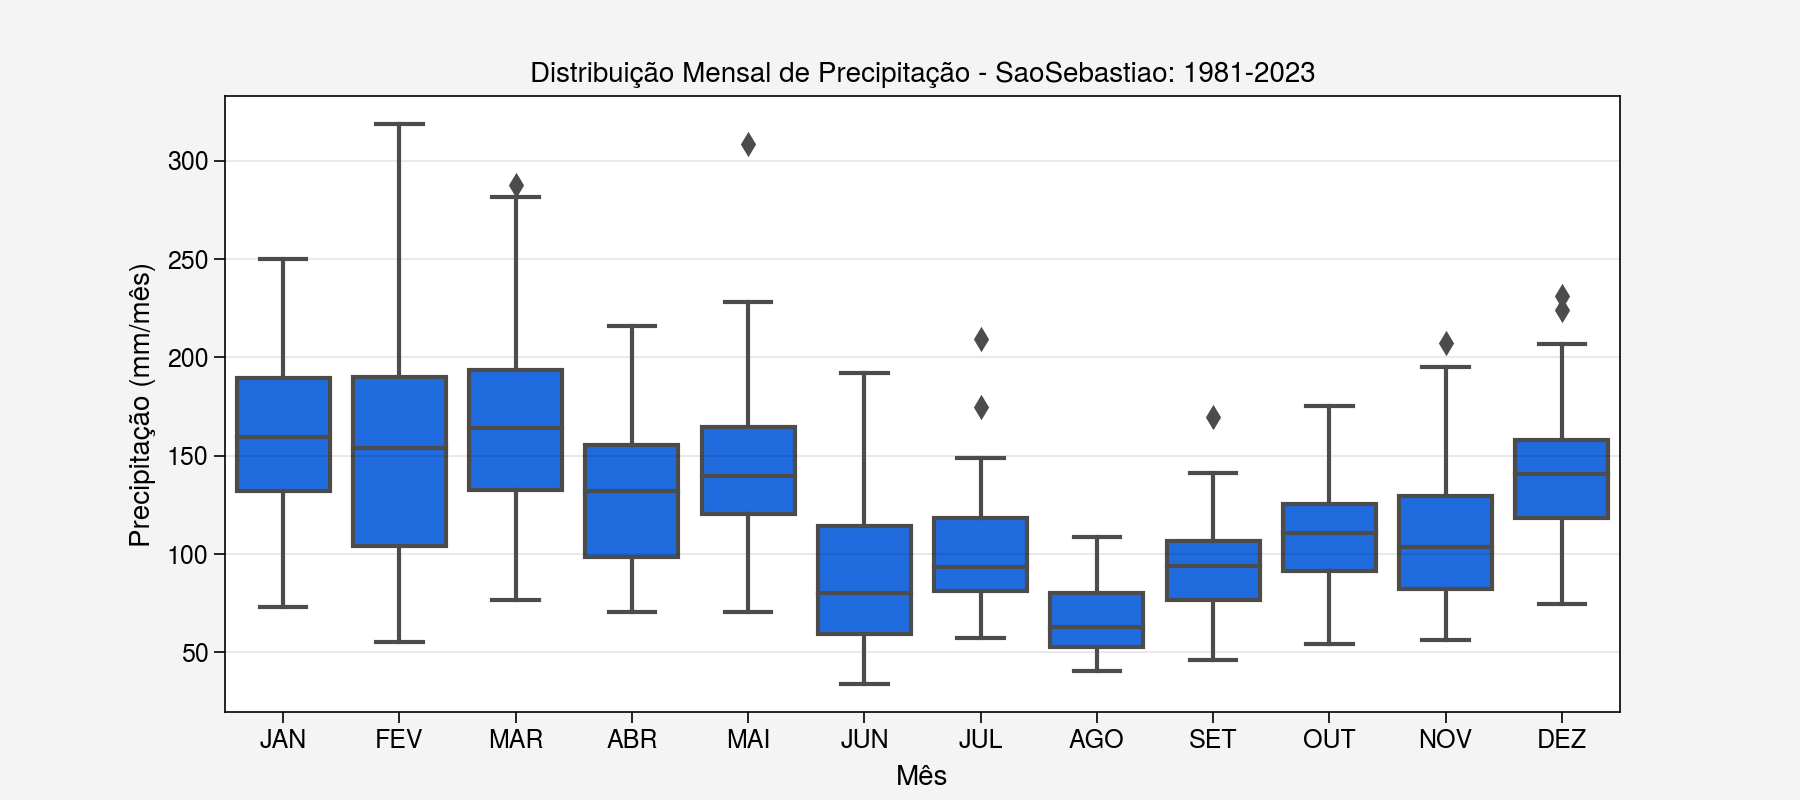

In [93]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=mensal.index.month,
            y=mensal['precipitation'],
            ax=ax,
            color='bright blue')

# formatação dos eixos
ax.set_title(f'Distribuição Mensal de Precipitação - {city}: {periodo}', fontsize=10)
ax.set_ylabel('Precipitação (mm/mês)', fontsize=10)
ax.set_xlabel('Mês', fontsize=10)
ax.set_xticklabels(['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'])
ax.minorticks_off()

# salva figura
plt.savefig(f'{dir}output/{city}_Fig3_precipitacao_mensal_distribuicao_chirps.jpg', dpi=300, bbox_inches='tight')

###**Plotando gráfico**: por mês - linha

- **Mensal Total**: gráfico total (linha)

In [77]:
mensal

,precipitation
date,
1981-01-31,170.915124
1981-02-28,93.580082
1981-03-31,214.568448
1981-04-30,120.482660
1981-05-31,78.324773
...,...
2023-01-31,130.903592
2023-02-28,318.742575
2023-03-31,153.273789


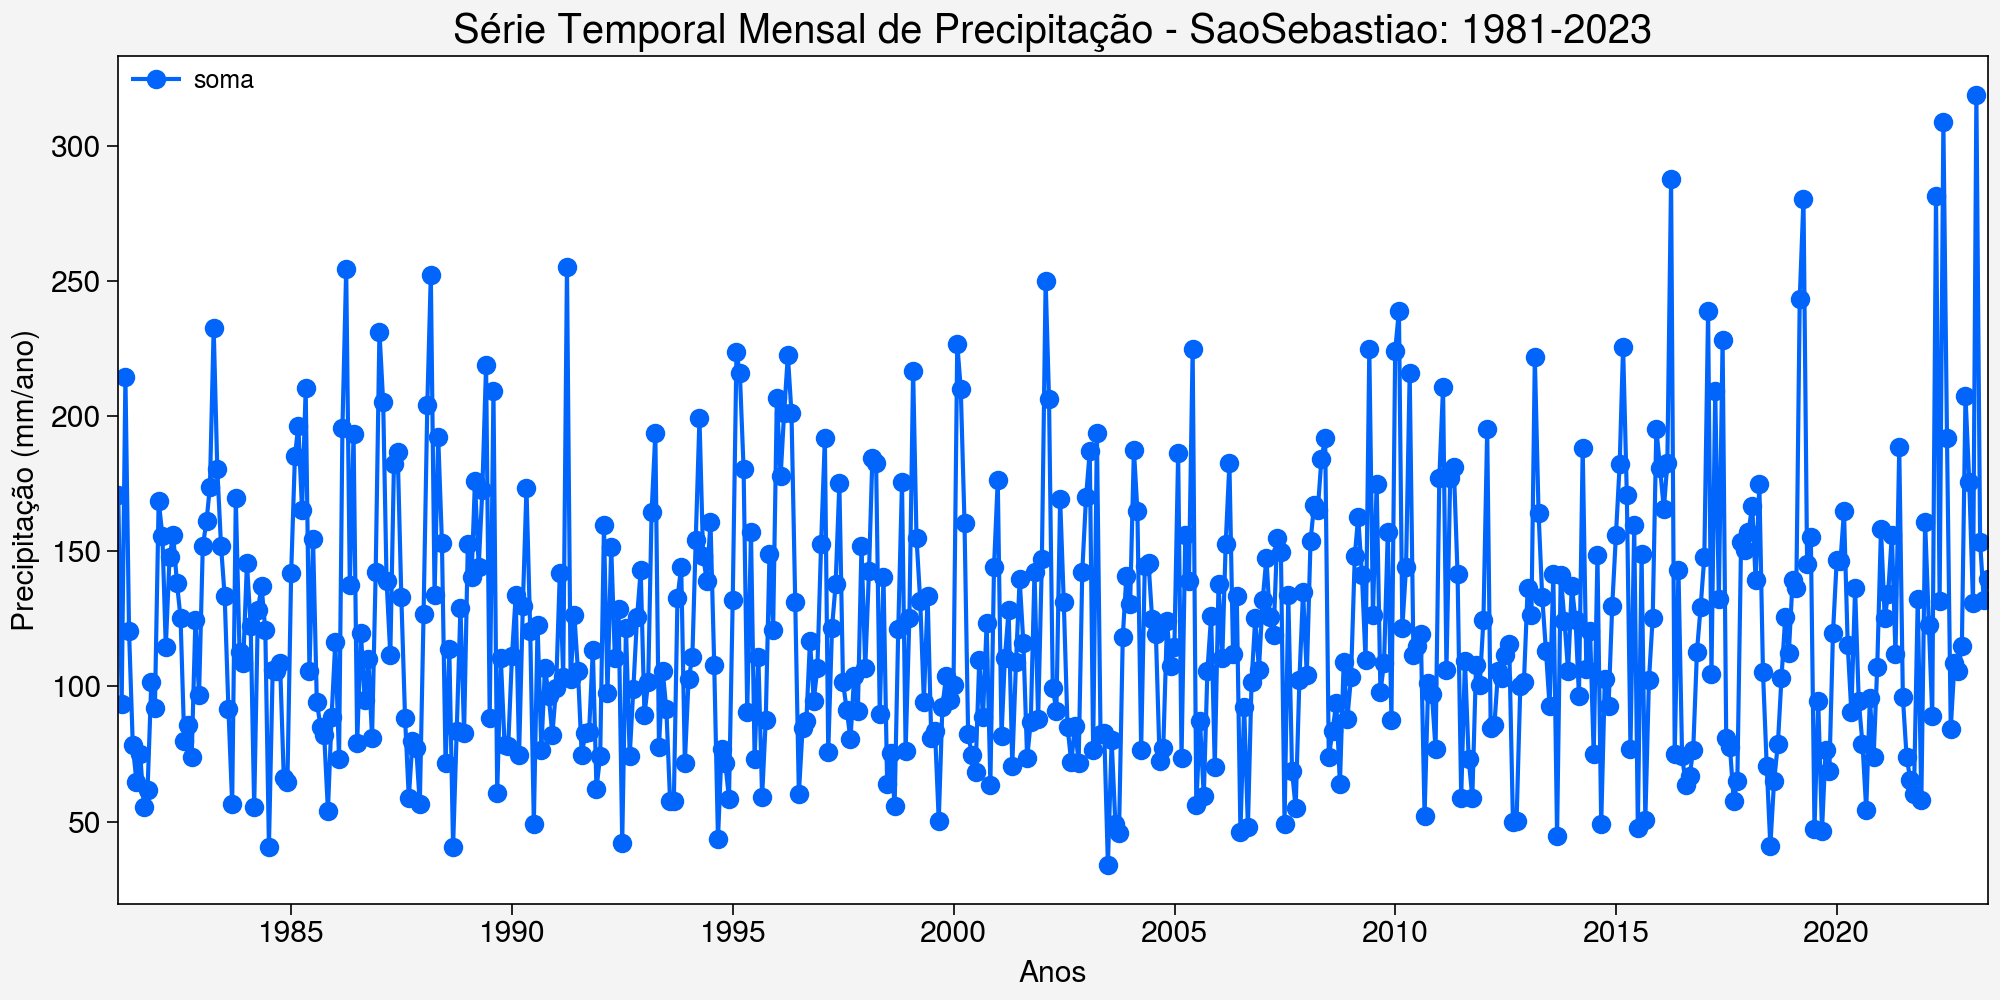

In [94]:
# moldura da figura
fig, ax = pplt.subplots(figsize=(10, 5), tight=True)

# plota figura
ax.plot(mensal.index,
        mensal['precipitation'].values,
        color='bright blue',
        marker='o',
        label ='soma')

# formato dos eixos
ax.format(xlabel='Anos', ylabel='Precipitação (mm/ano)',
          title=f'Série Temporal Mensal de Precipitação - {city}: {periodo}',
          xrotation=0, xtickminor=False, ytickminor=False,
          small='15px', large='20px', grid=False)

# legenda
ax.legend(frameon=False)

# salva figura
fig.save(f'{dir}output/{city}_Fig4_precipitacao_mensal_linear_chirps.jpg', dpi=300)

###**Plotando gráfico**: por mês - mensal climatológica

- **Mensal Climatológica**

In [78]:
mensal_climatologia

,precipitation
date,
1,162.990341
2,151.279198
3,170.027750
4,130.882263
5,147.189191
6,88.016563
7,102.669886
8,67.401857
9,92.694381


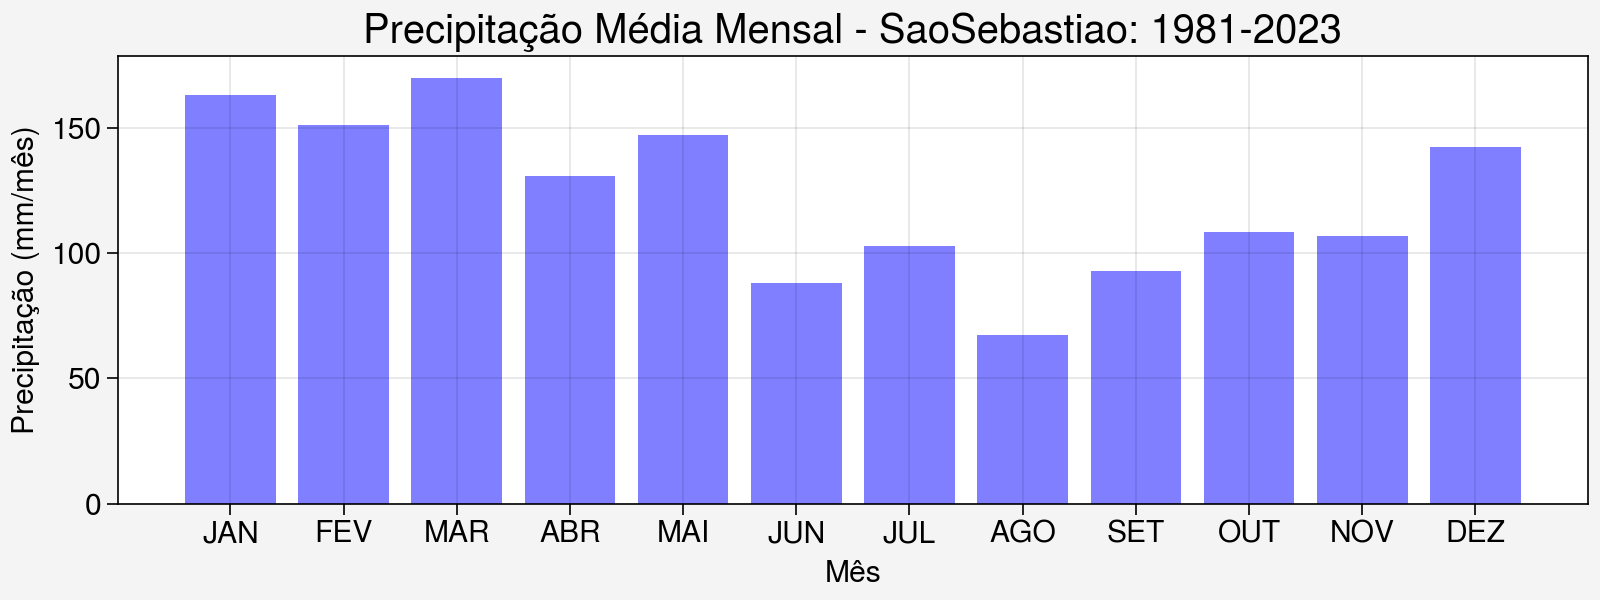

In [95]:
# moldura da figura
fig, ax = pplt.subplots(figsize=(8, 3), tight=True)

# plota figura
ax.bar(pplt.arange(1, 12, 1),
       mensal_climatologia['precipitation'],
       color='blue',
       alpha=0.5)

# formatação dos eixos
ax.format(xlabel='Mês',
          ylabel='Precipitação (mm/mês)',
          xtickminor=False,
          ytickminor=False,
          xticklabels=['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN',
                       'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
          xticks=pplt.arange(1, 12, 1),
          title=f'Precipitação Média Mensal - {city}: {periodo}',
          small='15px',
          large='20px')

# salva figura
fig.save(f'{dir}output/{city}_Fig5_precipitacao_mensal_climatologica_chirps.jpg', dpi=300)